In [143]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
from matplotlib import pyplot as plt
import csv

Define External Variables

In [144]:
WG = .02 # Defines how much wealth grows each period
TR = .3 #Tax Rate

Gini Coefficiant Calculator

In [145]:
def gini(x): ## Take in np array numbers
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

Function that when called, creates a seed generation, pandas Data Frame, and returns it

First generation makes first voting choice

If your wealth is greater then median income, vote for no taxes, False

If your wealth is less then median income, vote for taxes, True

In [146]:
def ppl0(): ##Sets up the first, 0th, generation
    w = np.random.randint(1,11,size=10)
    w.sort() # random wealth distrobution, 1-10, sorted
    ppl0 = pd.DataFrame({'Name': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'], 'W': w}) #base values of the first generation
    ppl0['WRich'] = ppl0.apply(lambda row: True if row['W'] >= np.mean(ppl0.W) else False, axis=1) #Says if they are wealth rich, meaning above average
    ppl0['IRich'] = False #No income yet, they are all not income rich
    ppl0["Income"] = 0   ## No income from previous period
    ppl0["Taxed"] = 0   ##Noting is taxed from previous period  
    ppl0["SB"] = 0 #.1*(ppl0['W']/max(ppl0['W']))  #Random change buffer, higher value means higher avg expected draw. Is proportional to wealth compared to max
    ppl0["Vote"] = ppl0.apply(lambda row: False if row['WRich'] == True else True, axis=1) # Rich people vote no for redistrobution #will be based on probabilities and wealth later
    return ppl0


Function automatically resets everything and creates new seed first generation 0

Each gneration of people, a pd DataFrame, is put into the list ppl

In [147]:
def reset0(): ## Restarts all data
    ppl = [ppl0()] #creates list of generations of people
    elect = [False] #Creates a list that will collect all election outcomes
    G = [gini(ppl[0]['W'])] ## Creates list of every gini coefficient for each period/generation
    return ppl, elect, G

In [148]:
ppl, elect, G = reset0()
ppl[0] # calls the first generation, genderation 0, the seed generation

,Name,W,WRich,IRich,Income,Taxed,SB,Vote
0,A,3,False,False,0,0,0,True
1,B,4,False,False,0,0,0,True
2,C,4,False,False,0,0,0,True
3,D,6,False,False,0,0,0,True
4,E,7,True,False,0,0,0,False
5,F,7,True,False,0,0,0,False
6,G,8,True,False,0,0,0,False
7,H,8,True,False,0,0,0,False
8,I,8,True,False,0,0,0,False
9,J,9,True,False,0,0,0,False


This function, when called, creates a new generation, ppl t

ppl t to is added to the list of generations, appended right after ppl t-1

In [149]:
def NextPeriod():
    t = len(ppl) ## current period, shortcut to finding this is just to count how many gnerations there are on the "ppl" list
    ppl.append(ppl[t - 1].copy()) ## creates copy of previous period
    
    Outcome = False #Outcome of voting is automatically False, no taxes
    if ppl[t - 1]["Vote"].value_counts()[True] >= ppl[t - 1]["Vote"].value_counts()[False]: Outcome = True ## Outcome of voting is True, taxes, if a majority of people last peiod voted True
    elect.append(Outcome) ## Adds voting outcomes to list of election outcomes
    
    ppl[t]['Income'] = ppl[t]['W']*(WG) ## calculates income fro individual (wealth * wealth growth rate) 
    ppl[t]['Income'] = ppl[t].apply(lambda row: row['Income'] 
                        + (row['W'] * np.random.normal(loc=row['SB'], scale=.1)) #adds random chance income, proportional to wealth
                        + (sum(ppl[t-1]['Taxed']) * np.random.beta(a = 3, b = 3*(len(ppl[t]) - 1))), axis = 1) #adds benefits of taxes through investment, on average all the benefits of the tax are distributed since mean is Total taxed / number of people #using beta distrobution
    ## I hope you know I am actually really clever for figuring out how to create a beta distrobution with a set mean
    MeanI = np.mean(ppl[t]['Income']) ## Defining Variable Mean Wealth
    
    ppl[t]['IRich'] = ppl[t].apply(lambda row: True if row['Income'] >= MeanI else False, axis=1) #Says if individuals is income rich, meaning above average
    ppl[t]["Taxed"] = ppl[t].apply(lambda row: (row['Income'] - MeanI)*TR if row['IRich'] == True else 0, axis=1) #calculates how much they are taxed in the current period
    
    ppl[t]['W'] = ppl[t]['W'] + ppl[t]['Income'] - ppl[t]["Taxed"] ## Wealth is previous period wealth, plus income, plus tax
    ppl[t]['W'] = ppl[t].apply(lambda row: max(1, row['W']), axis = 1) ## min wealth is 1, no negative wealth, they get reset
    
    MeanW = np.mean(ppl[t]['W']) ## Defining Variable Mean Wealth
    ppl[t]['WRich'] = ppl[t].apply(lambda row: True if row['W'] >= MeanW else False, axis=1) #Says if individuals are wealth rich, meaning above average
    ppl[t]["SB"] = 0 # irrelavent, too powerful, not using anymore #.1*(ppl[t]['W']/max(ppl[t]['W'])) #chance buffer proportional to wealth compared to max wealth
    ppl[t]["Vote"] = ppl[t].apply(lambda row: False if row['WRich'] == True else True, axis=1) # Rich people vote no for taxes, not rish people for for taxes #will be based on probabilities and wealth later
    
    G.append(gini(ppl[t]['W'])) ## calcuates this period's gini coefficient and adds it to the list for each period/generation
    
    return t ## Return the current / latest period, just makes thing easy

Every time this function is called, a new generation/period is created and their welth is graphed

In [150]:
def GraphNextWealth():
    t = NextPeriod() #calls the function creating the next period and returns the current period t and voting outcome
    GraphW = sns.barplot(data=ppl[t], x="Name", y="W", estimator= 'mean', order = ppl[t].sort_values('W').Name) #Wealth distrobution graph
    GraphW.set(title = f"Wealth in Period {t}, Outcome is {elect[t]}, Gini is {G[t]:.3f}", label = True) #, ybound=[0,50],)
    GraphW.bar_label(GraphW.containers[0])
    GraphW.axhline(y = np.mean(ppl[t]['W']), color = 'darkgreen')

In [151]:
#GraphNextWealth()

Sample Output:

![alt text](wealthGraphBasic.png "Title")

Wealth Distrobution of the period after the seed gneration, ppl 0

In [152]:
def run(r = 100): #iterates/creates "r" new period, automatically 100 if not specified when called
    for i in range(r): NextPeriod() 

"probF" Function is my attempt at calcuating the probabality of switching from state "Taxes" to "No Taxes"

It takes the sum of the times it switches states from "Taxes" to "No Taxes" by the number times it is in state "Taxes"

In [153]:
def probF():
    isT = 0 #counts how many times the value is T
    stF = 0 #counts how many times T switches to F
    
    for i in range(len(elect)-1):
        if elect[i] == True: isT += 1
        if elect[i] == False and elect[i-1] == True: stF += 1
        
    return (stF/isT)

This "plot gini" function plotd the gini in each period as well as the voting outcomes

1 = Taxes, 
0 = No Taxes

It also display the current Tax Rate, Avg, Gini over all periods, and the probability of switching, "probF" as described above

In [154]:
def plotGini(): ## creates plot with election outcomes and gini over time
    plt.plot(elect)
    plt.plot(G)
    plt.xlabel(f"Period, t = {len(ppl) - 1}")
    plt.ylabel(f"Tax Policy in Effect = 1, Avg. Gini ({np.mean(G):.3f})")
    plt.title(f"Tax Rate =  {TR}, Probability of Switching = {probF():.3f}")

In [155]:
#run(1000)
#plotGini()

Sample Output:

![alt text](plotGiniBasic.png "Title")

Inequality tends to rise when there are not taxes, blue line is at 0

In [156]:
#probF()

"AvgG" calculates the average Gini coefficient for different values of the Tax Rate

This is simple for runtime purposes. We are going by Tax Rate intervuls of .1. We are only doing one simulation of 100 generations per Tax Rate. We would need way more intervuls, simulations, and periods to be accuate.

In [157]:
def AvgG():
    AvgG = pd.DataFrame({'TR': [], 'AvgG': []}) #creates a list of Average Gini
    for TTR in range(10):  # only 10 TR, 0-1
        TR = TTR * .1 ## TR intervuls of .1
        ppl, elect, G = reset0() # resets and seeds ppl 0
        run(1000) # itterate/creates 1000 generations using tax rate TR
        
        AvgG.loc[len(AvgG)] = [TR, np.mean(G)] ## Adds avg gini to list for each iteration at differnt TR
        
    return AvgG

In [158]:
def GraphAvgG(): ## Graphs the "AvgG" function
    AvgGD = AvgG()
    GraphAG = sns.lineplot(data = AvgGD, x = AvgGD['TR'], y = AvgGD['AvgG'])
    GraphAG.set(ybound = [0,1])

In [159]:
#GraphAvgG()

Sample Output:

![alt text](AvgGiniWithDifferentTR1k.png "Title")

Average Gini (Y-Axis) trends down as TR (X-axis) increases

---------------------------------------
Probability switching Tax to No Tax per Tax Rate, "probFTR" does the same thing as Avg Gini except with "probF" as defined above. 

Simulates 1000 generations/periods once for each Tax Rates


In [160]:
def probFTR():
    probFTR = pd.DataFrame({'TR': [], 'ProbF': []}) #probF list
    for TTR in range(10):
        TR = TTR * .1 ## .1 intervuls for Tax Rate
        ppl, elect, G = reset0() # reset
        run(1000) #  itterate/creates 1000 generations using tax rate TR
        
        probFTR.loc[len(probFTR)] = [TR, probF()] ## Adds avg to list for each iteration
        
    return probFTR

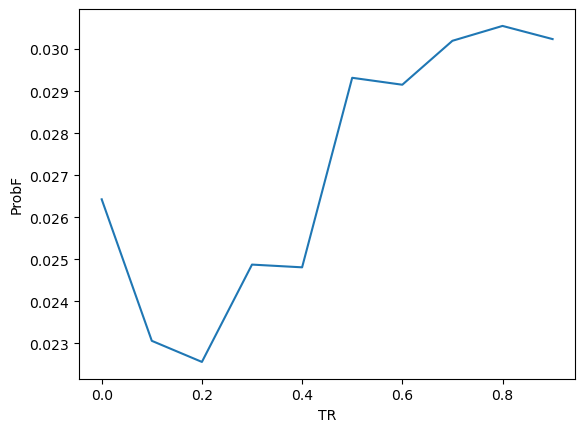

In [161]:
probFD = probFTR()
GraphProbF = sns.lineplot(data = probFD, x = probFD['TR'], y = probFD['ProbF']) ## Graph probFTR

Sample Output:

![alt text](SwitchPerTR2.png "Title")

As Tax Rates Increase, the probability of switching from "Taxes" to "No Taxes" increases. This is because high taxes make the disrobution more equal and more likely that the Voting Outcome will be for "No Taxes" in each period.

In [162]:
## Next
## Change voting to be based on percieved outcomes
## Delay voting / median Income, so probibility that they will be taxed in the period
## Calculate the inequality and making voting based on that
## collect the data and average over several times
## iterate over different r
## gini is actuallly good for measuring the distrobution but bad for advising next steps, or measuring the changes and directions of inequality
## Can change election laws, see impact
## Add more tax
## probabalistic income predictions, people hate being not rich in the future